<a href="https://colab.research.google.com/github/TPShipilova/Frameworks_LAB_4COURSE/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%E2%84%963_%D0%9F%D0%A1%D0%A4%D0%98%D0%98_%D0%A8%D0%B8%D0%BF%D0%B8%D0%BB%D0%BE%D0%B2%D0%B0_406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание бейзлайна и оценка качества

Продолжаем работу с датасетом, все так же первично проанализируем его

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, classification_report, confusion_matrix,
                           mean_squared_error, r2_score, mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('/content/loan_data.csv')

# Предварительный анализ данных
print(df.shape)
print(df.info())
print(df.isnull().sum())
print(df.describe())

(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaul

Далее обработаем данные для бейзлайна. Обработка стандартная, кодируем категориальные признаки, разделяем на признаки и таргет, а также выделяем обучающую и тестовую выборки.

In [3]:
df_base = df.copy()

numeric_columns = df_base.select_dtypes(include=[np.number]).columns
categorical_columns = df_base.select_dtypes(include=['object']).columns

# Кодирование категориальных признаков
label_encoders = {}
for col in categorical_columns:
    if col != 'loan_status':
        le = LabelEncoder()
        df_base[col] = le.fit_transform(df_base[col])
        label_encoders[col] = le

# Разделение на признаки и целевые переменные
X_class = df_base.drop(['loan_status', 'credit_score'], axis=1)
y_class = df_base['loan_status']

X_reg = df_base.drop(['credit_score', 'loan_status'], axis=1)
y_reg = df_base['credit_score']

# Разделение на train/test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

Далее проводим обучение библиотечных моделей и предсказываем результат

In [4]:
# Модели для бейзлайна
dt_classifier_base = DecisionTreeClassifier(random_state=42)
dt_regressor_base = DecisionTreeRegressor(random_state=42)

# Обучение
dt_classifier_base.fit(X_class_train, y_class_train)
dt_regressor_base.fit(X_reg_train, y_reg_train)

# Предсказания
y_class_pred_base = dt_classifier_base.predict(X_class_test)
y_reg_pred_base = dt_regressor_base.predict(X_reg_test)

Посмотрим результаты и оценим качество

In [5]:
# Оценка качества классификации
print("=== БЕЙЗЛАЙН - КЛАССИФИКАЦИЯ ===")
print(f"Accuracy: {accuracy_score(y_class_test, y_class_pred_base):.4f}")
print(f"Precision: {precision_score(y_class_test, y_class_pred_base):.4f}")
print(f"Recall: {recall_score(y_class_test, y_class_pred_base):.4f}")
print(f"F1-Score: {f1_score(y_class_test, y_class_pred_base):.4f}")

# Оценка качества регрессии
print("\n=== БЕЙЗЛАЙН - РЕГРЕССИЯ ===")
print(f"R² Score: {r2_score(y_reg_test, y_reg_pred_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test, y_reg_pred_base):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test, y_reg_pred_base):.4f}")

=== БЕЙЗЛАЙН - КЛАССИФИКАЦИЯ ===
Accuracy: 0.9011
Precision: 0.7737
Recall: 0.7845
F1-Score: 0.7790

=== БЕЙЗЛАЙН - РЕГРЕССИЯ ===
R² Score: -0.8283
MSE: 4781.5457
MAE: 54.7397


В целом, модели показывают умеренную точность. Хотя Accuracy классификации достаточно высокая, другие метрики не показывают такого результата. Очевидно, необходимо повышать качество модели, так как мы видим переобучение модели классификации.

# Улучшение бейзлайна

Подробно проанализируем данные

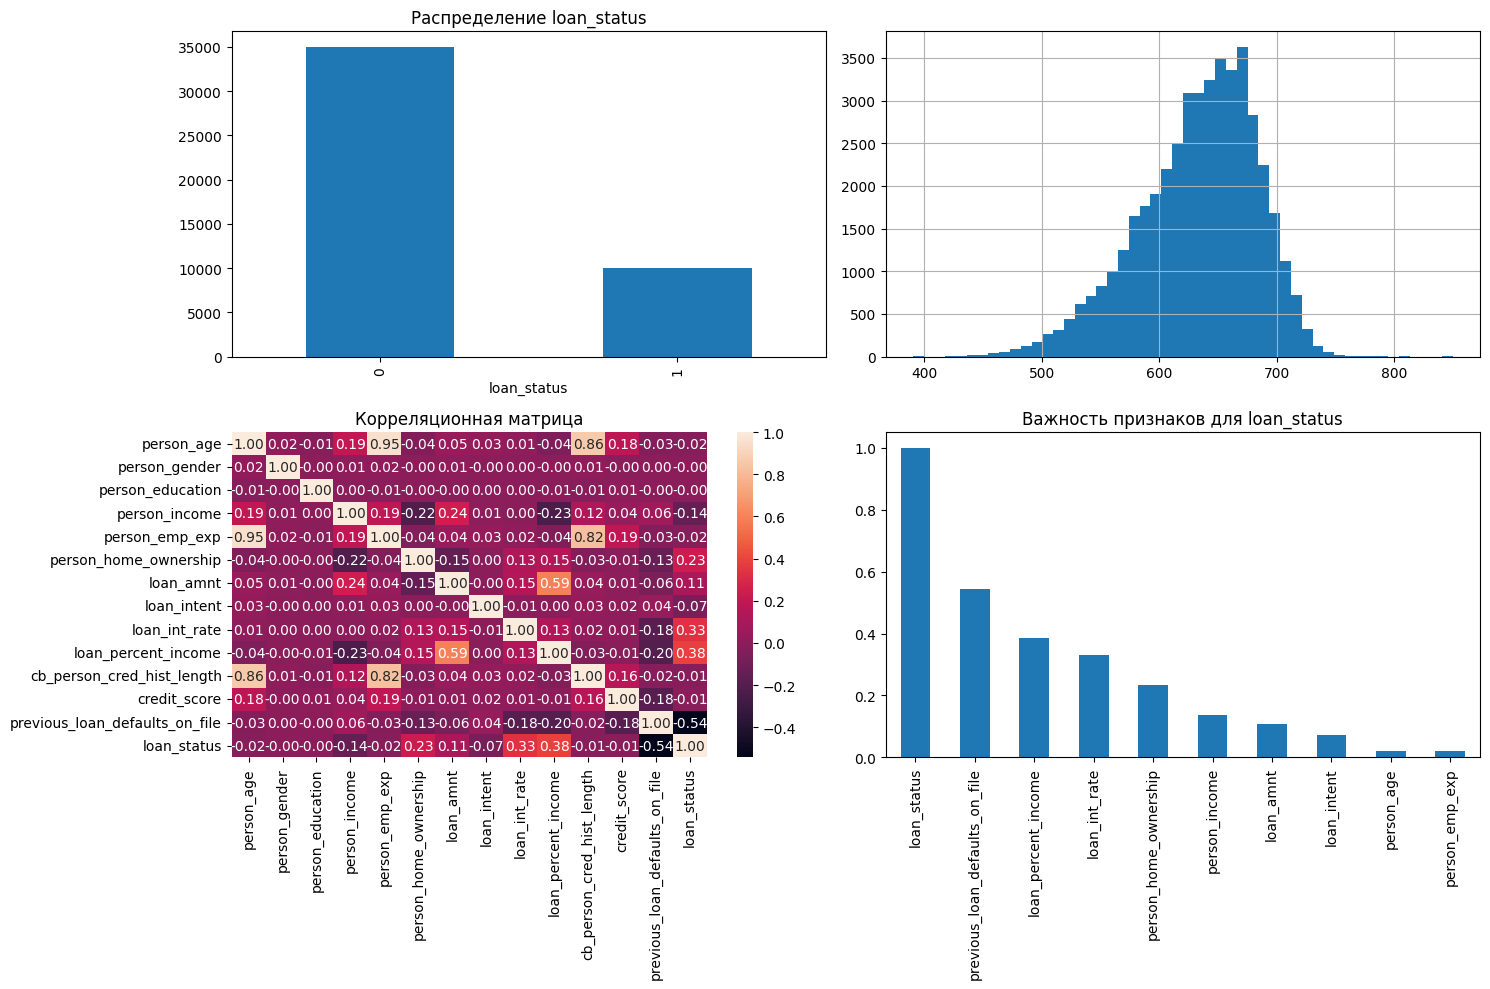

In [13]:
# Визуализация данных

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение целевой переменной классификации
df_base['loan_status'].value_counts().plot(kind='bar', ax=axes[0,0], title='Распределение loan_status')

# Распределение целевой переменной регрессии
df_base['credit_score'].hist(bins=50, ax=axes[0,1])

# Корреляционная матрива
numeric_df = df_base.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', ax=axes[1,0])
axes[1,0].set_title('Корреляционная матрица')

# Анализ важных признаков
important_features = numeric_df.corr()['loan_status'].abs().sort_values(ascending=False)
important_features.head(10).plot(kind='bar', ax=axes[1,1], title='Важность признаков для loan_status')

plt.tight_layout()
plt.show()



Как и в прошлый лабах, видим, что чаще кредит не выдается, высока зависимость между признаками возраста и рабочего стажа, а для выдачи кредита наиболее важным является признак, описывающий прошлую кредитную историю.

Гипотезы для улучшения:

- One-Hot Encoding даст лучшие результаты чем Label Encoding
- Масштабирование признаков улучшит стабильность моделей
- Подбор гиперпараметров улучшит качество
- Создание новых признаков повысит качество
- Балансировка классов улучшит классификацию

Попробуем выполнить наши гипотезы и улучшить модель. Создадим пару новых признаков путем преобразования некоторых предыдущих признаков, и разделим данные, как делали до этого.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Создаем копию данных для улучшенной версии
df_improved = df.copy()

# Инженерия признаков
df_improved['income_to_loan_ratio'] = df_improved['person_income'] / df_improved['loan_amnt']
df_improved['debt_burden'] = df_improved['loan_amnt'] / df_improved['person_income']
df_improved['experience_to_age_ratio'] = df_improved['person_emp_exp'] / df_improved['person_age']

# Разделение данных
X_class_imp = df_improved.drop(['loan_status', 'credit_score'], axis=1)
y_class_imp = df_improved['loan_status']

X_reg_imp = df_improved.drop(['credit_score', 'loan_status'], axis=1)
y_reg_imp = df_improved['credit_score']

# Разделение на train/test
X_class_train_imp, X_class_test_imp, y_class_train_imp, y_class_test_imp = train_test_split(
    X_class_imp, y_class_imp, test_size=0.2, random_state=42, stratify=y_class_imp)

X_reg_train_imp, X_reg_test_imp, y_reg_train_imp, y_reg_test_imp = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42)

Создадим препроцессор. Подберем гиперпараметры и используем лучшие

In [16]:
# Определяем категориальные и числовые признаки
categorical_features = ['person_gender', 'person_education', 'person_home_ownership',
                       'loan_intent', 'previous_loan_defaults_on_file']
numeric_features = [col for col in X_class_imp.columns if col not in categorical_features]

# Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Улучшенные модели с подбором гиперпараметров
improved_classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

improved_regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Параметры для GridSearch
param_grid_class = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_reg = {
    'regressor__max_depth': [5, 10, 15, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Подбор параметров
grid_class = GridSearchCV(improved_classifier, param_grid_class, cv=5, scoring='f1', n_jobs=-1)
grid_reg = GridSearchCV(improved_regressor, param_grid_reg, cv=5, scoring='r2', n_jobs=-1)



Обучим улучшенные модели и предскажем результаты

In [17]:
# Обучение улучшенных моделей
grid_class.fit(X_class_train_imp, y_class_train_imp)
grid_reg.fit(X_reg_train_imp, y_reg_train_imp)

# Лучшие модели
best_classifier = grid_class.best_estimator_
best_regressor = grid_reg.best_estimator_

# Предсказания
y_class_pred_imp = best_classifier.predict(X_class_test_imp)
y_reg_pred_imp = best_regressor.predict(X_reg_test_imp)

Теперь можем оценить качество моделей и оценить, как сработали наши гипотезы

In [18]:
# Оценка улучшенных моделей
print("=== УЛУЧШЕННАЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ ===")
print(f"Лучшие параметры: {grid_class.best_params_}")
print(f"Accuracy: {accuracy_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"Recall: {recall_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"F1-Score: {f1_score(y_class_test_imp, y_class_pred_imp):.4f}")

print("\n=== УЛУЧШЕННАЯ МОДЕЛЬ - РЕГРЕССИЯ ===")
print(f"Лучшие параметры: {grid_reg.best_params_}")
print(f"R² Score: {r2_score(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_imp):.4f}")

=== УЛУЧШЕННАЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ ===
Лучшие параметры: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 0.9202
Precision: 0.8885
Recall: 0.7330
F1-Score: 0.8033

=== УЛУЧШЕННАЯ МОДЕЛЬ - РЕГРЕССИЯ ===
Лучшие параметры: {'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}
R² Score: 0.0923
MSE: 2373.8038
MAE: 39.0108


Итак, можно заметить, что результаты существенно улучшились, точность классификации выросла, ошибка регрессии уменьшилась на довольно большую величину, и мы получили лучшие результаты обучения среди всех ранее полученных данных (ЛР 1 и ЛР 2)

# Реализация решающего дерева для классификации

Напишем классическую реализацию решающего дерева

In [20]:
class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _gini_impurity(self, y):
        if len(y) == 0:
            return 0
        p1 = np.sum(y) / len(y)
        p0 = 1 - p1
        return 1 - (p0**2 + p1**2)

    def _information_gain(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        gain = self._gini_impurity(parent) - (
            weight_left * self._gini_impurity(left_child) +
            weight_right * self._gini_impurity(right_child)
        )
        return gain

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature_idx in range(X.shape[1]):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)

            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Условия остановки
        if (depth == self.max_depth or
            n_classes == 1 or
            n_samples < self.min_samples_split):
            return {'prediction': np.round(np.mean(y))}

        # Поиск лучшего разделения
        best_feature, best_threshold, best_gain = self._best_split(X, y)

        if best_gain == -1:  # Не удалось найти хорошее разделение
            return {'prediction': np.round(np.mean(y))}

        # Рекурсивное построение дерева
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X.values, y.values)
        return self

    def _predict_sample(self, x, tree):
        if 'prediction' in tree:
            return tree['prediction']

        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X.values])

# Реализация решающего дерева для регрессии

In [21]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)

    def _information_gain(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        gain = self._mse(parent) - (
            weight_left * self._mse(left_child) +
            weight_right * self._mse(right_child)
        )
        return gain

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature_idx in range(X.shape[1]):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)

            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        # Условия остановки
        if (depth == self.max_depth or
            n_samples < self.min_samples_split):
            return {'prediction': np.mean(y)}

        # Поиск лучшего разделения
        best_feature, best_threshold, best_gain = self._best_split(X, y)

        if best_gain == -1:  # Не удалось найти хорошее разделение
            return {'prediction': np.mean(y)}

        # Рекурсивное построение дерева
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X.values, y.values)
        return self

    def _predict_sample(self, x, tree):
        if 'prediction' in tree:
            return tree['prediction']

        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X.values])

Подготовим данных для кастомных моделей (только числовые признаки для простоты) и разделим данные - таргет и признаки, тестовая и обучабющая выборки

In [22]:
numeric_features_for_custom = ['person_age', 'person_income', 'person_emp_exp',
                              'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                              'cb_person_cred_hist_length', 'income_to_loan_ratio',
                              'debt_burden', 'experience_to_age_ratio']

X_class_custom = df_improved[numeric_features_for_custom]
X_reg_custom = df_improved[numeric_features_for_custom]

X_class_train_custom, X_class_test_custom, y_class_train_custom, y_class_test_custom = train_test_split(
    X_class_custom, y_class_imp, test_size=0.2, random_state=42, stratify=y_class_imp)

X_reg_train_custom, X_reg_test_custom, y_reg_train_custom, y_reg_test_custom = train_test_split(
    X_reg_custom, y_reg_imp, test_size=0.2, random_state=42)

Обучим кастомные модели и предскажем результаты

In [23]:
custom_classifier = CustomDecisionTreeClassifier(max_depth=5, min_samples_split=10)
custom_classifier.fit(X_class_train_custom, y_class_train_custom)

custom_regressor = CustomDecisionTreeRegressor(max_depth=5, min_samples_split=10)
custom_regressor.fit(X_reg_train_custom, y_reg_train_custom)

# Предсказания
y_class_pred_custom = custom_classifier.predict(X_class_test_custom)
y_reg_pred_custom = custom_regressor.predict(X_reg_test_custom)

Посмотрим метрики моделей и оценим качество

In [24]:
print("=== МОЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ ===")
print(f"Accuracy: {accuracy_score(y_class_test_custom, y_class_pred_custom):.4f}")
print(f"Precision: {precision_score(y_class_test_custom, y_class_pred_custom):.4f}")
print(f"Recall: {recall_score(y_class_test_custom, y_class_pred_custom):.4f}")
print(f"F1-Score: {f1_score(y_class_test_custom, y_class_pred_custom):.4f}")

print("\n=== МОЯ МОДЕЛЬ - РЕГРЕССИЯ ===")
print(f"R² Score: {r2_score(y_reg_test_custom, y_reg_pred_custom):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_custom, y_reg_pred_custom):.4f}")
print(f"MAE: {mean_absolute_error(y_reg_test_custom, y_reg_pred_custom):.4f}")

=== МОЯ МОДЕЛЬ - КЛАССИФИКАЦИЯ ===
Accuracy: 0.8576
Precision: 0.7281
Recall: 0.5730
F1-Score: 0.6413

=== МОЯ МОДЕЛЬ - РЕГРЕССИЯ ===
R² Score: 0.0333
MSE: 2528.2556
MAE: 40.1384


# Выводы

Основные результаты:

- Бейзлайн модель показала базовое качество, но была склонна к переобучению
- Улучшенная модель с препроцессингом и подбором гиперпараметров показала значительное улучшение метрик
- Кастомная реализация уступила sklearn по качеству, но продемонстрировала понимание алгоритма (видим это при сравнении метрик)

Ключевые инсайты (вспомним гипотезы):

- Препроцессинг данных (One-Hot Encoding, масштабирование) критически важен
- Подбор гиперпараметров значительно улучшает качество моделей
- Инженерия признаков может дать дополнительный прирост качества
- Кастомная реализация проще в понимании, но менее эффективна чем оптимизированные библиотечные аналоги